### The purpose of this notebook is to demonstrate how to improve RAG operations by agumenting your queries in two ways: 1) by generating a hypothetical answer for the query and 2) by expanding your query with additional similar generated queries.

### The notebook is adapted from a free short course I took with Chorma on DeepLearning.AI

### A single query is just one vector in the embedding space and does not represent a whole lot. By expanding the query, you can increase the chances of getting more diverse results from the embedding space. See the plots in this notbook and compare them with the ones in the "prrojecting_and_visualizing_embeddings" notebook.

#### Source: https://learn.deeplearning.ai/advanced-retrieval-for-ai/lesson/4/query-expansion

In [1]:
!pip install --upgrade --quiet pypdf python-dotenv umap-learn chromadb \
    langchain huggingface_hub sentence-transformers

In [5]:
# If you want to ignore warnings, you can uncomment.
# I presonally like to see warnings since they may expose
# deprecations, missing libraries, etc. Why ignore these?
# import warnings
# warnings.filterwarnings("ignore")

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
from huggingface_hub import login
_ = load_dotenv(find_dotenv()) # read local .env file
hugging_face_access_token = os.environ['HUGGINGFACEHUB_API_TOKEN']
login(hugging_face_access_token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/studio-lab-user/.cache/huggingface/token
Login successful


In [3]:
# Note: don't run this cell twice. It will break.
# If you want to start running from top, restart the kernel

from embedding_utils import load_chroma, word_wrap
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf',
    collection_name='microsoft_annual_report_2022',
    embedding_function=embedding_function)

chroma_collection.count()

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


349

In [6]:
# projects embeeding into a two dimensional vector that prserves
# the distances of the elements in the embedding query as opposed to PCA, for example,
# that selects the dimensions with highest variances.
import numpy as np
from tqdm import tqdm
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

In [7]:
# https://pypi.org/project/umap-learn/

# fit a projection model to project embeddings 
# into a lower dimensional space
# for furhter info: https://pypi.org/project/umap-learn/

import umap
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 349/349 [06:17<00:00,  1.08s/it]


In [8]:
# created this dataclass and plotting function
# TODO: move this into a utility

from dataclasses import dataclass

@dataclass
class PlotLayer:
    embedding: list
    size: int = None
    color: str = None
    facecolor: str = None
    edgecolor: str = None
    marker: str = None


import matplotlib.pyplot as plt
%matplotlib inline

def plot_projections(title, PlotLayers: list[PlotLayer], legend: list[str] = []) -> None:
    plt.figure()
    for PlotLayer in PlotLayers:
        plt.scatter(PlotLayer.embedding[:, 0], PlotLayer.embedding[:, 1],
            s=PlotLayer.size, marker=PlotLayer.marker, color=PlotLayer.color,
            facecolor = PlotLayer.facecolor, edgecolor=PlotLayer.edgecolor)

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title)
    plt.axis('off')
    if len(legend) > 0:
        plt.legend(legend)

In [9]:
# Create a chat model with a HuggingFace LLM
import llm_utils
llm = llm_utils.HuggingFaceHub(
    repo_id="HuggingFaceH4/zephyr-7b-beta",
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 512,
        "top_k": 30,
        "temperature": 0.1,
        "repetition_penalty": 1.03,
    },
)

chat_model = llm_utils.ChatHuggingFace(llm=llm)

WARNING! repo_id is not default parameter.
                    repo_id was transferred to model_kwargs.
                    Please confirm that repo_id is what you intended.
WARNING! task is not default parameter.
                    task was transferred to model_kwargs.
                    Please confirm that task is what you intended.
WARNING! huggingfacehub_api_token is not default parameter.
                    huggingfacehub_api_token was transferred to model_kwargs.
                    Please confirm that huggingfacehub_api_token is what you intended.


In [10]:
# Query expansion with generated hypothetical answer
from langchain.schema import HumanMessage, SystemMessage
from langchain.prompts import ChatPromptTemplate
def augment_query_generated(query, chat_model):

    system_message = """
        You are a helpful expert financial research assistant.
        Provide an example answer to the given question,
        that might be found in a document like an annual report.
    """

    messages = [
      SystemMessage(content=system_message),
      HumanMessage(
        content=query
      ),
    ]

    response = chat_model.invoke(messages)

    return response.content

In [12]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query, chat_model=chat_model)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

Was there significant turnover in the executive team? Yes, there was
notable turnover in our executive team during the past year. We
regretfully announced the departure of our Chief Financial Officer
(CFO) in March due to personal reasons. In May, we appointed a new CFO
with extensive experience in our industry. Additionally, our Chief
Operating Officer (COO) retired in August after a successful tenure
with the company. We have since promoted an internal candidate to fill
this role, who has been with the company for over a decade and has
demonstrated strong leadership skills. We believe that these changes
will strengthen our leadership team and position us for continued
growth and success.


In [13]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

88 report of independent registered public accounting firm to the
stockholders and the board of directors of microsoft corporation
opinion on internal control over financial reporting we have audited
the internal control over financial reporting of microsoft corporation
and subsidiaries ( the “ company ” ) as of june 30, 2022, based on
criteria established in internal control — integrated framework ( 2013
) issued by the committee of sponsoring organizations of the treadway
commission ( coso ). in our opinion, the company maintained, in all
material respects, effective internal control over financial reporting
as of june 30, 2022, based on criteria establis hed in internal control
— integrated framework ( 2013 ) issued by coso. we have also audited,
in accordance with the standards of the public company accounting
oversight board ( united states ) ( pcaob ), the consolidated financial
statements as of and for the year ended june 30, 2022, of the company
and

the company engaged deloitt

In [14]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


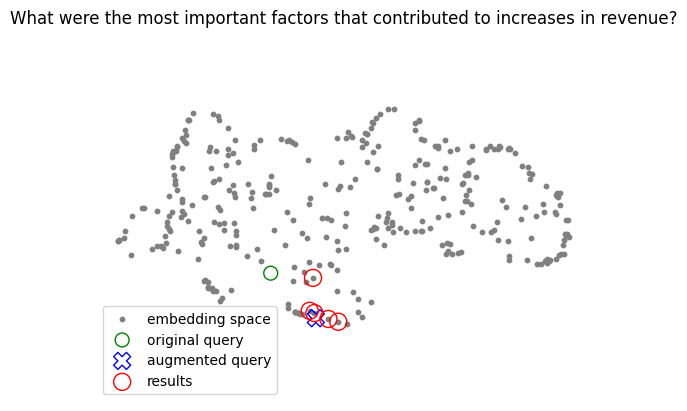

In [23]:
PlotLayers = [PlotLayer(embedding=projected_dataset_embeddings, size=10, color='gray'),
          PlotLayer(embedding=projected_original_query_embedding, size=100, facecolor='none', edgecolor='g'),
          PlotLayer(embedding=projected_augmented_query_embedding, size=150, marker='X', facecolor='none', edgecolor='blue'),
          PlotLayer(embedding=projected_retrieved_embeddings, size=150, facecolor='none', edgecolor='red')]
legend = ['embedding space', 'original query', 'augmented query', 'results']
plot_projections(title=original_query, PlotLayers=PlotLayers, legend=legend)

In [16]:
# Query expansion with multiple queries
import regex as re
def augment_multiple_query(query, chat_model):

    system_message = """
        You are a helpful expert financial research assistant.
        Your users are asking questions about an annual report.
        Suggest up to five additional related questions to help them find
        the information they need, for the provided question.
        Suggest only short questions without compound sentences.
        Suggest a variety of questions that cover different aspects of the topic.
        Make sure they are complete questions,
        and that they are related to the original question.
        Output one question per line. Line numbers are not needed.
    """

    messages = [
      SystemMessage(content=system_message),
      HumanMessage(
        content=query

      ),
    ]
    response = chat_model.invoke(messages)
    content = response.content
    #chat model returns numbered lists as in 1. <text>
    #check and remove numbers.
    pattern = re.compile("[0-9]")
    output = [question[2:].strip() if pattern.match(question) else question.strip()
        for question in content.split('\n')]
    return output

In [17]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query, chat_model=chat_model)
for query in augmented_queries:
    print(query)

What were the top-performing products or services that led to the revenue growth?
How did the company's marketing strategies impact revenue?
Were there any significant changes in pricing strategies that contributed to revenue growth?
Did the company experience any notable increases in sales volume or market share?
How did foreign exchange rates affect revenue during the reporting period?


In [18]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
engineering, gaming, and linkedin. • sales and marketing expenses
increased $ 1. 7 billion or 8 % driven by investments in commercial
sales and linkedin. sales and marketing included a favorable foreign
currency impact of 2 %. • general and administrative expenses increased
$ 793 million or 16 % driven by investments in corporate functions.
operating income increased $ 13. 5 billion or 19 % driven by growth
across each of our segments. current year net income and diluted eps
were positively impacted by the net tax benefit related to the transfer
of intangible properties, which resulted in an increase to net income
and diluted eps of $ 3. 3 billion and $ 0. 44, respectively. prior year
net income and diluted eps were positively impacted by the net tax
benefit related to the india supreme court decision on withholding
taxes, which resulted in an increase to net income and diluted eps of $
620 

In [19]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


In [20]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


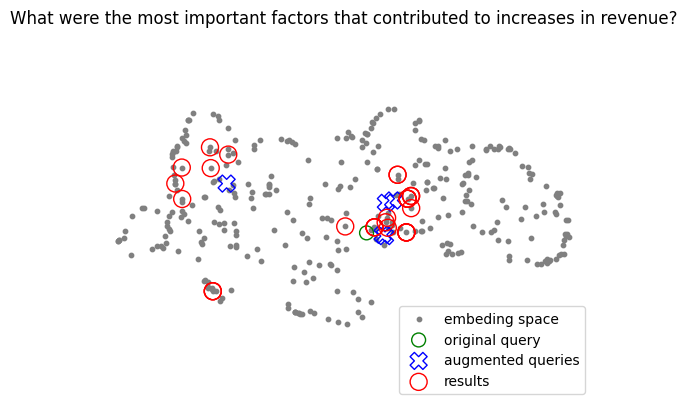

In [24]:
PlotLayers = [PlotLayer(embedding=projected_dataset_embeddings, size=10, color='gray'),
          PlotLayer(embedding=project_original_query, size=100, facecolor='none', edgecolor='g'),
          PlotLayer(embedding=project_augmented_queries, size=150, marker='X', facecolor='none', edgecolor='blue'),
          PlotLayer(embedding=projected_result_embeddings, size=150, facecolor='none', edgecolor='red')]
legend = ["embeding space", "original query", "augmented queries", "results"]
plot_projections(title=original_query, PlotLayers=PlotLayers, legend=legend)